In [56]:
import scipy.io
mat = scipy.io.loadmat('flow_invi_mesh.mat')
# coords in element
gnum=mat['t']
# coord location
gcoord=mat['p']  
edge=mat['e']

U=1

node=3
nip=3
ndim=2

In [57]:
## initialize gaussian points

In [58]:
import numpy as np
a=np.zeros((3,2,4))
points=np.zeros((3,3))
points[0,0]=0.5
points[0,1]=0.5
points[0,2]=0
points[1,0]=0.5
points[1,1]=0
points[1,2]=0.5
points[2,0]=0
points[2,1]=0.5
points[2,2]=0.5

c=0.5
wts=c*(1/3)*np.ones((1,nip))


In [59]:
fun_s=np.zeros((nip,node))
der_s=np.zeros((nip,2,3))
der=np.zeros((2,3))

for k in range(nip):
    L1=points[0,k]
    L2=points[1,k]
    L3=points[2,k]
    fun=[L1,L2,L3]
    fun_s[k,:]=fun
    
    der[0,0]=1
    der[0,1]=0
    der[0,2]=-1
    der[1,0]=0
    der[1,1]=1
    der[1,2]=-1
    der_s[k,:,:]=der

In [60]:
# gnum=gnum
g_num=gnum[[0,1,2],:]-1
x_coord=gcoord[0,:]
y_coord=gcoord[1,:]
# system size
x_size=max(x_coord)
y_size=max(y_coord)
# number of elements
nels=len(gnum[0,:])
# number of nodes
nn=len(x_coord)


# x0 boundry
x0=np.where(x_coord<=0+0.0001)

# xl boundry
xl=np.where(x_coord>=x_size-0.0001)
# gnum index in boundry
x0=x0[0]
xl=xl[0]
# boundry element
boundry_x0=[]
boundry_xl=[]

for i in range(nels):
    item=g_num[:,i]
    ii0=0
    iil=0
    for coord in item:
        if coord in x0:
            ii0+=1 
    for coord in item:
        if coord in xl:
            iil+=1     
    if ii0==2:
        boundry_x0.append(i)
    if iil==2:
        boundry_xl.append(i)    
    


In [61]:
bv=np.zeros((nn,1))
lhs=np.zeros((nn,nn))

In [62]:
for i in range(nels):
    num=g_num[:,i]
    coord=gcoord[:,num]
    coord=np.transpose(coord)
    KM=np.zeros((node,node))
    for k in range(nip):
        der=der_s[k,:,:]
        jac=np.dot(der,coord)
        detjac=np.linalg.det(jac)
        invjac=np.linalg.inv(jac)
        deriv=np.dot(invjac,der)
        tr_drive=np.transpose(deriv)
        KM+=np.dot(tr_drive,deriv)*detjac*wts[0,k]
    jj=0
    ll=0
    for j in num:
        ll=0
        for l in num:
            lhs[j,l]+=KM[jj,ll]
            ll+=1
        jj+=1
    
    

In [63]:
for i in boundry_x0:
    num1=g_num[:,i]
    coord=gcoord[:,num1]
    coord=np.transpose(coord)
    mv=np.zeros((node,1))
    y=[]
    i0=0
    for j in coord:
        if j[0]==0:
            mv[i0]=1
            y.append(j[1])
        i0+=1    
        b=np.abs(np.diff(y))
    Fb=U*b/2*mv
    bv[num1]=bv[num1]-Fb

In [64]:
for i in boundry_xl:
    num2=g_num[:,i]
    coord=gcoord[:,num2]
    coord=np.transpose(coord)
    mv=np.zeros((node,1))
    y=[]
    i0=0
    for j in coord:
        if j[0]==x_size:
            mv[i0]=1
            y.append(j[1])
        i0+=1    
        b=np.abs(np.diff(y))
    Fb=U*b/2*mv
    bv[num2]=bv[num2]+Fb


In [65]:
import numpy as np

from scipy.sparse import csc_matrix

from scipy.sparse.linalg import spsolve

A = csc_matrix(lhs, dtype=float)

B = csc_matrix(bv, dtype=float)

displ = spsolve(A, B)

In [66]:
# displ=np.dot(np.linalg.inv(lhs),bv)

In [67]:
potential =[]
t_gnum=np.transpose(g_num)
for item in t_gnum:
    potential.append(np.mean(displ[item]))

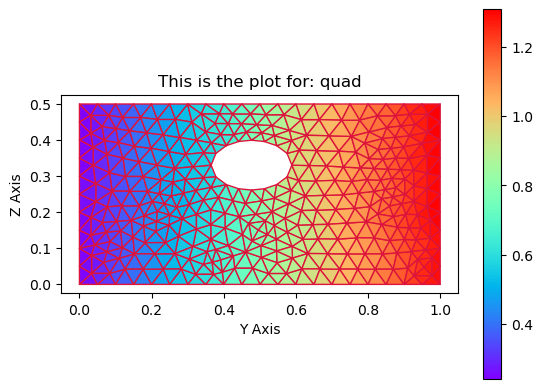

In [68]:
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np


def showMeshPlot(nodes, elements, values):

    y = nodes[:,0]
    z = nodes[:,1]

    def quatplot(y,z, quatrangles, values, ax=None, **kwargs):

        if not ax: ax=plt.gca()
        yz = np.c_[y,z]
        verts= yz[quatrangles]
        pc = matplotlib.collections.PolyCollection(verts, **kwargs)
        pc.set_array(values)
        ax.add_collection(pc)
        ax.autoscale()
        return pc

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    pc = quatplot(y,z, np.asarray(elements), values, ax=ax, 
             edgecolor="crimson", cmap="rainbow")
    fig.colorbar(pc, ax=ax)        
    ax.plot(y,z, marker="", ls="", color="crimson")

    ax.set(title='This is the plot for: quad', xlabel='Y Axis', ylabel='Z Axis')

    plt.show()
nodes = np.transpose(gcoord)
elements = np.transpose(g_num)


showMeshPlot(nodes, elements, potential)
